# Practical 1: Predator-Prey (Lotka Volterra)

## The Statistical Model

This example follows a simple analysis of the Lotka Volterra model for predator and prey populations where the measurement error for the data is assumed to be Gaussian.

$X_{1,t}$ the population of the prey, $X_{2,t}$ the population of the predator at time $t$. These evolve according to:

$$
\frac{dx_1}{dt} = (\alpha -\beta x_2 )x_1 \qquad
\frac{dx_2}{dt} = (\beta x_1 - \gamma )x_2     
$$

Observe a noisy measurement at times $t=0, 2, ..., 50$. 
$$
Y_{1,t} \sim \mathcal{N}(X_{1,t}, \sigma^2), \qquad Y_{2,t} \sim \mathcal{N}(X_{2,t}, \sigma^2)
$$

We implement this model and simulate data with parameters $\alpha=0.3$, $\beta = 0.04$, $\gamma=0.5$ and $\sigma = 1$. 


### Simulate some data

First we need to define the ODE in Julia. 

In [1]:
using DifferentialEquations

# Define the deterministic model
function lotka_volterra(dx, x, p, t)
    # Model parameters.
    α, β, γ = p
    # Current state.
    x1, x2 = x
    # Evaluate differential equations.
    dx[1] = (α - β * x2) * x1 # prey
    dx[2] = (β * x1 - γ) * x2 # predator

    return nothing
end


lotka_volterra (generic function with 1 method)

Then simulate some data and plot the results. It is important to have the Random library imported to make sure that the data is simulated with the same seed. Alternatively you could load in the data using the lines commented out in the code snippet below. Assume that the initial populations are $x_{1,0} = 7$ and $x_{2,0} = 5$ and that $\theta = (.3, .04, .5, 1)$

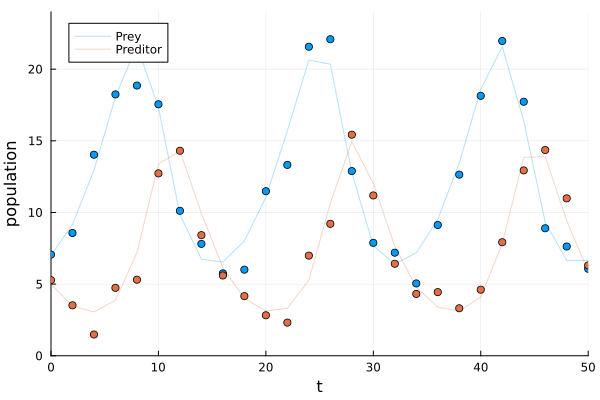

In [2]:
# Set a seed for reproducibility and import plotting packages
using Random
using StatsPlots

Random.seed!(1)
x0 = [7, 5]
tspan = (0.0, 50.0)
θ_dg = [0.3, 0.04, 0.5, 1.] # The data generating θ
prob = ODEProblem(lotka_volterra, x0, tspan)

save_at = 2.0
sol = solve(prob, p = θ_dg[1:3], saveat=save_at,  verbose = false)

# Noisy observations
y = Array(sol) + 1.0 * randn(size(Array(sol))) 

plot(sol; alpha=0.3, labels = ["Prey" "Preditor"], ylim =[0.0, 24], ylabel="population")
scatter!(sol.t, y'; color=[1 2], label="")

# using DelimitedFiles
# y = readdlm("lvsmc/prey_pred2.csv", ',', Float64)

## Define the likelihood and priors

For numerical stability we use the log likelihood of the data. We can evaluate the likelihood of the data for a set of parameters $\theta = (\alpha, \beta, \gamma, \sigma)$ by solving the ODE and calculating the probability of observing the noisy (Gaussian) measurements. 

In [3]:
function log_like(θ)

    α, β, γ, σ =  θ

    # Simulate Lotka-Volterra model. 
    predicted = solve(prob, p=[α, β, γ], saveat = save_at, verbose=false)

    if !SciMLBase.successful_retcode(predicted.retcode)
        # Simulation failed, return negative infinity
        return -Inf
    end

    # Add up the log likelihood for the observed data y.
    log_likelihood = 0.0
    Σ = diagm([σ^2, σ^2])
    for i in 1:length(predicted)
        like_dist = MultivariateNormal(predicted[:,i], Σ)
        log_likelihood += logpdf(like_dist, y[:,i])
    end
    return log_likelihood
end

log_like (generic function with 1 method)

We want to estimate ${\theta} = (\alpha, \beta, \gamma, \sigma)$ for the model. The Bayesian approach allows us to do this and to quantify the uncertainty of our estimates.

Assign some priors $\alpha, \gamma \sim U(0,1)$ $\beta \sim U(0,0.1)$ and $\sigma \sim U(0.1,7)$. For the SMC code we will need functions to evaluate the log prior and to simulate from the prior.

In [4]:
using Distributions
# Priors on: α, β, γ, σ 
priors = [Uniform(0., 1), Uniform(0,0.1), Uniform(0, 1), Uniform(0.1, 7)]

# Function to simulate from the prior
function sim_prior(N)
    mat = zeros(N, length(priors))
    for i in 1:N
        mat[i,:] = rand.(priors)
    end
    return mat
end

# Function to evaluate the log prior
function log_prior(θ)
    # Prior distributions.
    return sum(logpdf.(priors, θ))
end

log_prior (generic function with 1 method)

## Import the SMC code and run the algorithm

The SMC algorithm is discussed in the `smc_sampler_lanneal.ipynb` notebook and the code is imported into the session. Use the code to run the SMC algorithm, this may take a while to evaluate.

In [5]:
include("smc_sampler_lanneal_adaptive.jl")
particles = smc_sampler_lanneal_adaptive(5000, sim_prior, log_prior, log_like)

Current γ = 0.003242125507600251
Unique particles: 4997


Current γ = 0.026781187391655532
Unique particles: 4922


Current γ = 0.055515380567178
Unique particles: 4440


Current γ = 0.08151114546771321
Unique particles: 3212


Current γ = 0.11957046569474607
Unique particles: 2643


Current γ = 0.21919040186375227
Unique particles: 4991


Current γ = 0.3748841057834137
Unique particles: 5000


Current γ = 0.7379731874047328
Unique particles: 5000


Current γ = 1.0
Unique particles: 5000


5000×4 Matrix{Float64}:
 0.296302  0.0405163  0.502798  1.13537
 0.297997  0.0401224  0.501627  0.980391
 0.297621  0.0405341  0.500614  1.02856
 0.292026  0.0405536  0.521605  1.0057
 0.293502  0.0408469  0.51261   1.41901
 0.298407  0.0404237  0.492489  1.12762
 0.295893  0.0402938  0.507555  1.08392
 0.300008  0.0396404  0.493987  1.08077
 0.298075  0.0399757  0.495767  1.08045
 0.297812  0.0401764  0.502783  0.973716
 ⋮                              
 0.299222  0.039781   0.49216   0.94189
 0.297254  0.0398542  0.49781   0.998305
 0.296822  0.0401064  0.500572  1.01683
 0.299413  0.0398836  0.489606  0.861348
 0.297239  0.0398896  0.49527   1.03217
 0.294948  0.0405391  0.505154  1.13565
 0.295592  0.0407255  0.510159  0.940331
 0.294709  0.0404638  0.51052   1.21717
 0.293827  0.0396752  0.505739  0.949687

Compare the marginal distributions of the parameters to the data generating values.

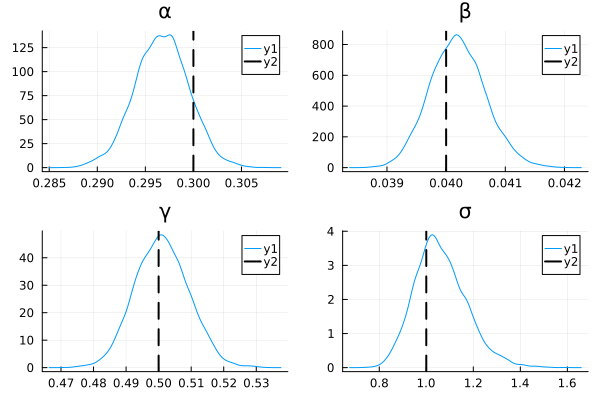

In [7]:
using KernelDensity

names = ["α", "β", "γ", "σ"]
p = []
for i in 1:4
    # dens = kde(exp.(samps[:,i]))
    dens = kde(particles[:,i])

    #x_tic = min(dens.x)
    p_l = plot(dens, title = names[i], ticks = :native)
    vline!([(θ_dg[i])], line = (:black, 2, :dash))
    push!(p,  p_l)
end
plot(p[1], p[2], p[3], p[4])

## Exercises

Some exercises for solidifying knowledge:

1. Read and implement this SMC sampler for the predator-prey model: **lv_smc_example.ipynb**
2. Adjust the code to implement the adaptive version of the sampler (smc_sampler_lanneal)
3. Try running the SMC sampler using the package SequentialMonteCarlo.jl **lvsmc**